# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откроем файл с данными и изучим общую информацию. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

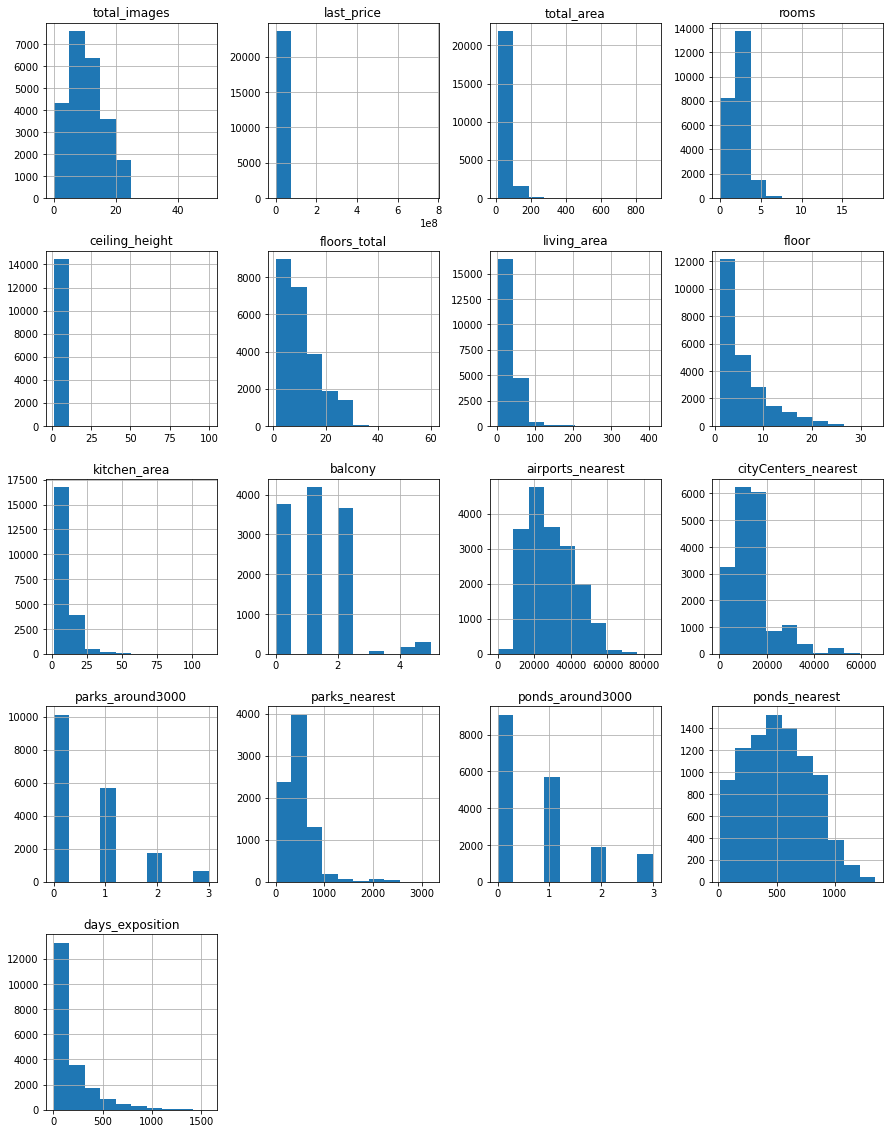

In [2]:
data.info()
data.hist(figsize=(15, 20))
plt.show()

Из общей информации мы видим, что всего 23699 записей. 
В большинстве столбцов значения пропущены, так же некорректные типы данных у некоторых столбцов.
На гистограммах прослеживаются аномальные значения.
Посмотрим всё более детально и исправим по возможности.

### Предобработка данных

In [3]:
#найдем пропущенные значения в столбцах и заполним их 
data['ceiling_height'] = data['ceiling_height']. fillna (data['ceiling_height']. median())
#удалим пропущенные значения в 'floors_total'(их мало - 86, на анализ не повлияет)
data.dropna(subset=['floors_total'], inplace=True)
data['is_apartment'] = data['is_apartment'].fillna(False)
data['balcony'] = data['balcony'].fillna(0)
#удалим пропущенные значения в 'locality_name'(их мало - 49, на анализ не повлияет)
data.dropna(subset=['locality_name'], inplace=True)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
# заменяим пустые значения жилой площади и площади кухни
living_ratio = data['living_area'].mean() / data['total_area'].mean()
kitchen_ratio = data['kitchen_area'].mean() / data['total_area'].mean()
data['living_area'].fillna(living_ratio * data['total_area'], inplace=True)
data['kitchen_area'].fillna(kitchen_ratio * data['total_area'], inplace=True)
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000            0
parks_nearest           15535
ponds_around3000            0
ponds_nearest           14529
days_exposition          3171
dtype: int64

В большинстве столбцов есть пропуски:

'ceiling_height'(высота потолков) - 9195 пропусков. Возможно, были пропущены из-за человеческого фактора, так как люди не знают высоту потолков в квартире. Заменим пропуски на медианное значение. 

'floors_total'(всего этажей в доме) - 86 пропусков. Возможно, пропущены из-за человеческого фактора.Можем их удалить, это не повлияет на дальнейший анализ из-за маленького количества пропусков, для замены значений у нас нет информации.

'living_area'(жилая площадь в квадратных метрах) - 1903 пропуска. Возможно, пропущены из-за человеческого фактора, пользователи, скорее всего, не знают точно жилую площадь квартиры и не написали ее.  Мы можем найти соотношение жилой площади в квадратных метрах и общей площади квартиры (среднее значение) и заменить пропущенные значения в этом столбце. 

'is_apartment'(апартаменты(булев тип) - 20924 пропусков. Также пользователи не указали(человеческий фактор) значения (если квартира не является апартаментами, они просто не указали это), в этом столбце булев тип данных и  пропуски заменим на False.

'kitchen_area'(площадь кухни в квадратных метрах) - 2278 пропусков. Пропущены из-за человеческого фактора, пользователи, скорее всего, не знают точно площадь кухни в квадратных метрах и не написали ее.  Мы можем найти соотношение площади кухни в квадратных метрах и общей площади квартиры (среднее значение) и заменить пропущенные значения в этом столбце. 

'balcony'(число балконов) - 11519 пропусков. Пользователь не указал число балконов, скорее всего, в квартире их нет. Такие пропуски правильно заменить на 0.

'locality_name'(название населенного пункта) - 49 пропусков. Пропусков мало, заменить названия нечем, можем удалить их, это не повлияет на дальнейший анализ. Тем более будет всё равно непонятно, где находится недвижимость.

'airports_nearest'(расстояние до ближайшего аэропорта) - 5542 пропусков. Возможно, пропущены из-за отсутствия информации на картографических данных.  Пока оставляем пропуски.

'cityCenters_nearest'(расстояние до центра города) - 5519 пропусков. Возможно, пропущены из-за отсутствия информации на картографических данных. Пока оставляем пропуски.

'parks_around3000'(число парков в радиусе 3км) - 5518 пропусков. Возможно, значения пропущены из-за того, что парков в радиусе 3 км нет. Заменим значения на 0.

'parks_nearest'(расстояние до ближайшего парка) - 15620 пропусков. Возможно, пропущены из-за отсутствия информации на картографических данных.  Пока оставляем пропуски.

'ponds_around3000'(число водоемов в радиусе 3 км)- 5518 пропусков. Одинаковое количество пропусков со столбцом 'parks_around3000'. Возможно, значения пропущены из-за того, что водоёмов в радиусе 3 км нет. Заменим значения на 0.

'ponds_nearest'(расстояние до ближайшего водоема) - 14589 пропусков. Возможно, пропущены из-за отсутствия информации на картографических данных.  Пока оставляем пропуски.

'days_exposition'(сколько дней было размещено объявление) - 3181 пропусков. Возможно, это техническая ошибка, потому что обычно число дней размещения объявления автоматически указывается после снятия объявления.  Пока оставляем пропуски.

In [4]:
# найдём столбцы, в которых нужно изменить тип данных и преобразуем их
data['last_price'] = data['last_price'].astype('int64')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['floors_total'] = data['floors_total'].astype('int64')
data['is_apartment'] = data['is_apartment'].astype('bool')
data['balcony'] = data['balcony'].astype('int64')
data['parks_around3000'] = data['parks_around3000'].astype('int64')
data['ponds_around3000'] = data['ponds_around3000'].astype('int64')
#остался столбец days_exposition, 
#нам нечем заменить значения 
#и пропусков 3181(их удаление может повлиять на анализ, пока оставим)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  int64         
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

Столбцы, в которых нужно изменить тип данных:

'last_price' на int64, цена должна быть целым числом,

'first_day_exposition' на datetime, дата публикации должна иметь тип данных  datetime64[ns],

'floors_total' на int64, этажи в доме - целые числа,

'is_apartment' на bool, по нашим данным - это булев тип данных и поэтому должно быть bool,

'balcony' на int64, количество балконов - целое число,

'parks_around3000' на int64, количество парков - целое число

'ponds_around3000' на int64, количество водоемов - целое число,

'days_exposition' на int64, количество дней размещения объявления - целое число.


In [5]:
data = data.apply(lambda x: x.replace({'поселок':'посёлок', 'городской посёлок': 'посёлок', 'посёлок городского типа': 'посёлок', 'коттеджный посёлок': 'посёлок', 'посёлок при железнодорожной станции': 'посёлок станции'}, regex=True))

len(data.locality_name.unique())

333

In [6]:
# проверим явные дубликаты и выведем их сумму
data.duplicated().sum()

0

Явных дубликатов нет.

(1.0, 6.0)

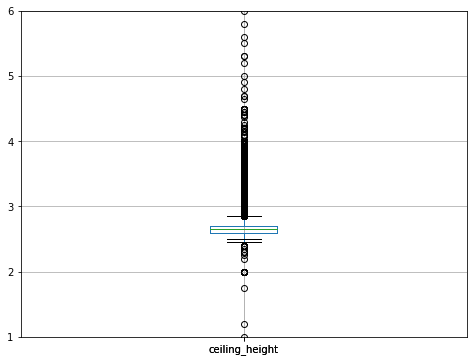

In [7]:
data.boxplot(column='ceiling_height', figsize=(8, 6))
plt.ylim(1, 6) 
#удалим квартиры с высотой потолков от 4 до 25 метров
#в квартирах с высотой потолков 25-32м (предполагаем, что на самом деле это вещественные значения: 2.5 м и 3.2 м.)
#восстановим корректные значения и поделим на 10, получая 2.5 и 3.2м
#удалим квартиры с высотой потолков от 32 метров
#удалим квартиры с высотой потолков менее 2.5 метра
data.drop(index=data.query('ceiling_height > 4 and ceiling_height < 25').index,inplace=True)
data.update(data[(data['ceiling_height'] >= 25) & (data['ceiling_height'] <= 32)]['ceiling_height']/10)
data.drop(index=data.query('ceiling_height > 32').index,inplace=True)
data.drop(index=data.query('ceiling_height < 2.5').index,inplace=True)
data.boxplot(column='ceiling_height', figsize=(8, 6))
plt.ylim(1, 6) 

Построив диаграмму размаха удалось выявить выбросы по значениям в столбце 'ceiling_height'. 
Было принято решение удалить квартиры с высотой потолков от 4 до 25 метров.
В квартирах с высотой потолков 25-32м (предполагаем, что на самом деле это вещественные значения: 2.5 м и 3.2 м.) - восстановить корректные значения и поделить на 10, получая 2.5 и 3.2м. Также были удалены квартиры с высотой потолков от 32 метров (явные аномалии),удалены квартиры с высотой потолков менее 2.5 метра.

### Проведем исследовательский анализ данных

In [8]:
data['price_of_one_square_meter'] = data['last_price'] / data['total_area']
data['day_of_the_publication_week'] = data['first_day_exposition'].dt.weekday
data['month_of_publication'] = data['first_day_exposition'].dt.month
data['year_of_publication'] = data['first_day_exposition'].dt.year
def floor_category(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_category, axis=1)
data['distance_to_the_city_center'] = round(data['cityCenters_nearest'] / 1000)
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_one_square_meter,day_of_the_publication_week,month_of_publication,year_of_publication,floor_type,distance_to_the_city_center
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.000000,8,False,...,482.0,2,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.600000,1,False,...,NaN,0,NaN,81.0,82920.792079,1,12,2018,первый,19.0
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.300000,4,False,...,90.0,2,574.0,558.0,92785.714286,3,8,2015,другой,14.0
3,0,64900000,159.00,2015-07-24,3,2.65,14,90.816648,9,False,...,84.0,3,234.0,424.0,408176.100629,4,7,2015,другой,7.0
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.000000,13,False,...,112.0,1,48.0,121.0,100000.000000,1,6,2018,другой,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.70,5,73.300000,3,False,...,796.0,3,381.0,NaN,72490.845228,1,3,2017,другой,4.0
23695,14,3100000,59.00,2018-01-15,3,2.65,5,38.000000,4,False,...,NaN,0,NaN,45.0,52542.372881,0,1,2018,другой,NaN
23696,18,2500000,56.70,2018-02-11,2,2.65,3,29.700000,1,False,...,NaN,0,NaN,NaN,44091.710758,6,2,2018,первый,NaN
23697,13,11475000,76.75,2017-03-28,2,3.00,17,43.837596,12,False,...,173.0,3,196.0,602.0,149511.400651,1,3,2017,другой,10.0


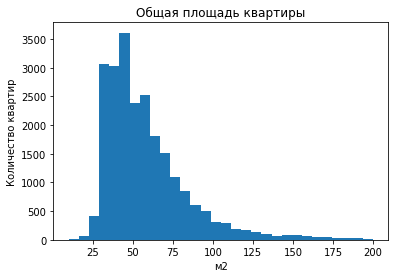

Квартиры с самой большой общей площадью: 19540    900.00
12859    631.20
3117     631.00
15651    618.00
5358     590.00
4237     517.00
15016    500.00
5893     500.00
9826     494.10
6621     488.00
660      483.90
6221     470.30
20273    460.80
3676     441.98
21955    431.00
Name: total_area, dtype: float64


In [9]:
# изучаем общие площади
plt.hist(data['total_area'], bins=30, range=(10,200))
plt.title('Общая площадь квартиры')
plt.xlabel('м2')
plt.ylabel('Количество квартир')
plt.show()
print('Квартиры с самой большой общей площадью:', data['total_area'].sort_values(ascending=False).head(15))

Есть квартиры с очень большой площадью, таких меньшинство. В основном, большая часть квартир менее 100 квадратных метров, пик количества квартир на 45 метрах.

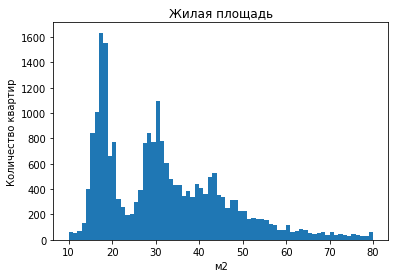

Квартиры с самой большой жилой площадью: 19540    409.700000
5358     409.000000
3117     360.410721
4237     332.000000
12859    322.300000
660      312.500000
14088    300.000000
15016    285.586942
5893     285.586942
9826     282.217016
Name: living_area, dtype: float64


In [10]:
# изучаем жилые площади
plt.hist(data['living_area'], bins=70, range=(10,80))
plt.title('Жилая площадь')
plt.xlabel('м2')
plt.ylabel('Количество квартир')
plt.show()
print('Квартиры с самой большой жилой площадью:',data['living_area'].sort_values(ascending=False).head(10))

На графике видно, что самые распространенные квартиры от 10 до 50 метров. На графике есть пики, возможно, это выдающиеся значения по однокомнатным, двухкомнатным и трехкомнатным квартирам

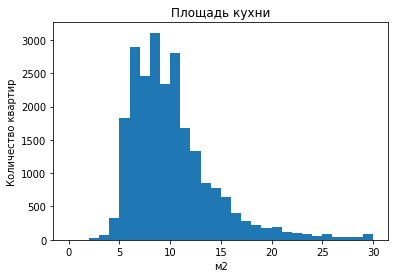

Квартиры с самой большой площадью кухни: 19540    112.000000
20215    107.000000
2489     100.700000
5358     100.000000
16239     93.200000
16797     93.000000
15016     87.537299
10867     87.200000
9826      86.504359
492       77.000000
Name: kitchen_area, dtype: float64


In [11]:
# изучаем площади кухни
plt.hist(data['kitchen_area'], bins=30, range=(0,30))
plt.title('Площадь кухни')
plt.xlabel('м2')
plt.ylabel('Количество квартир')
plt.show()
print('Квартиры с самой большой площадью кухни:',data['kitchen_area'].sort_values(ascending=False).head(10))

На графике видно, что самые распространенные площади кухонь - 7-13. Более 20 метров2 кухни встречаются редко.

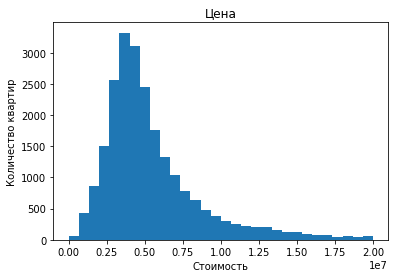

Самые дорогие квартиры: 12971    763000000
19540    420000000
14706    401300000
1436     330000000
15651    300000000
22831    289238400
16461    245000000
13749    240000000
5893     230000000
8900     190870000
Name: last_price, dtype: int64


In [12]:
# изучаем цены объекта
plt.hist(data['last_price'], bins=30, range=(0,20000000))
plt.title('Цена')
plt.xlabel('Стоимость')
plt.ylabel('Количество квартир')
plt.show()
print('Самые дорогие квартиры:',data['last_price'].sort_values(ascending=False).head(10))

Большая часть квартир стоит около 4 миллионов, но есть очень дорогие квартиры,но их немного.

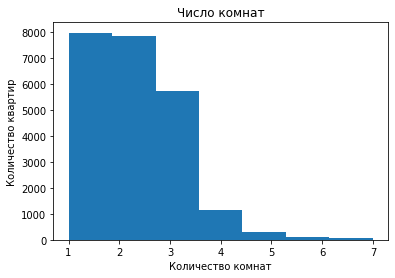

Квартиры с самым большим количеством комнат: 14498    19
18848    16
5358     15
20829    14
866      14
19540    12
9688     11
648      11
4149     10
18119    10
Name: rooms, dtype: int64


In [13]:
# изучаем количество комнат
plt.hist(data['rooms'], bins=7, range=(1,7))
plt.title('Число комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')
plt.show()
print('Квартиры с самым большим количеством комнат:', data['rooms'].sort_values(ascending=False).head(10))

График наглядно показывает, что самое большое количество квартир - это однокомнатные, двухкомнатые и трехкомнатные квартиры, есть немного квартир с четырями комнатами. Мало квартир с комнатами более 5, и есть совсем многокомнатые квартиры, их очень мало.

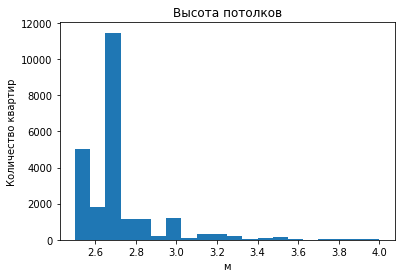

Квартиры с самыми высокими потолками: 7696     4.0
13890    4.0
14794    4.0
7618     4.0
3773     4.0
10228    4.0
14900    4.0
22083    4.0
11765    4.0
4549     4.0
Name: ceiling_height, dtype: float64


In [14]:
# изучаем высоты потолков
plt.hist(data['ceiling_height'], bins=20)
plt.title('Высота потолков')
plt.xlabel('м')
plt.ylabel('Количество квартир')
plt.show()
print('Квартиры с самыми высокими потолками:', data['ceiling_height'].sort_values(ascending=False).head(10))

Большая масса квартир с потолками 2,5 - 3 метров (меньше всего из них 2,9 м). Остальные значения встречаются редко.

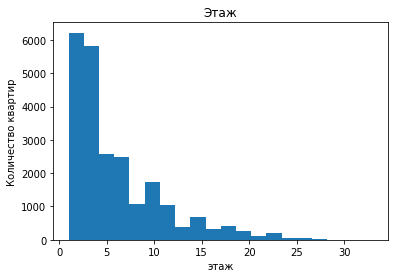

Квартиры на самых высоких этажах: 18218    33
11575    32
18629    31
1917     30
11079    29
397      28
2629     27
4091     27
13276    27
12888    27
Name: floor, dtype: int64


In [15]:
plt.hist(data['floor'], bins=20)
plt.title('Этаж')
plt.xlabel('этаж')
plt.ylabel('Количество квартир')
plt.show()
print('Квартиры на самых высоких этажах:', data['floor'].sort_values(ascending=False).head(10))

 Большинство квартир - это квартиры на 1,2,3 этаже. Реже встречаются с 4 по 7. 

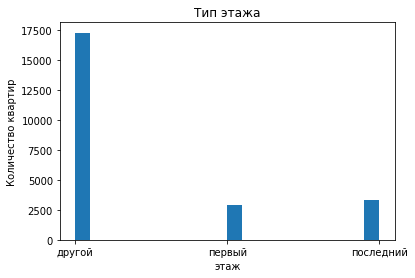

In [16]:
plt.hist(data['floor_type'], bins=20)
plt.title('Тип этажа')
plt.xlabel('этаж')
plt.ylabel('Количество квартир')
plt.show()

В основном квартиры расположены на этажах между первым и последним (другой). На первом и последним этажах имеют примерно одинаковые значения и их не так много. 

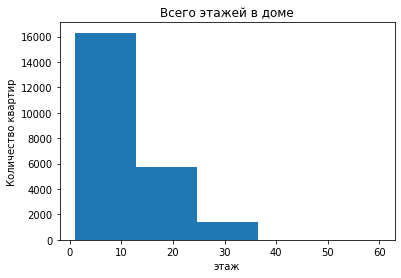

In [17]:
plt.hist(data['floors_total'], bins=5)
plt.title('Всего этажей в доме')
plt.xlabel('этаж')
plt.ylabel('Количество квартир')
plt.show()

Большинство квартир имеют этажность дома до 10 этажей (у нас в России в основном это пятиэтажные и девятиэтажные дома), реже встречаются дома с большей этажностью. 

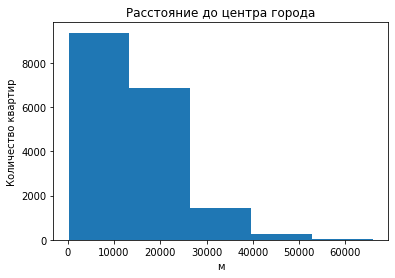

In [18]:
plt.hist(data['cityCenters_nearest'], bins=5)
plt.title('Расстояние до центра города')
plt.xlabel('м')
plt.ylabel('Количество квартир')
plt.show()

Большинство квартир расположены на расстоянии до 13км от центра. Остальные квартиры представлены реже

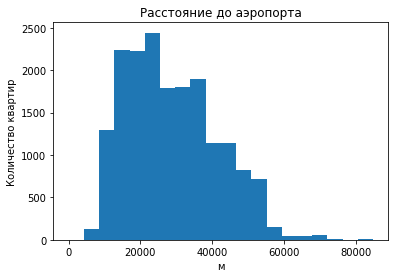

In [19]:
plt.hist(data['airports_nearest'], bins=20)
plt.title('Расстояние до аэропорта')
plt.xlabel('м')
plt.ylabel('Количество квартир')
plt.show()

Большинство квартир расположены на расстоянии 17-22 км от центра. 

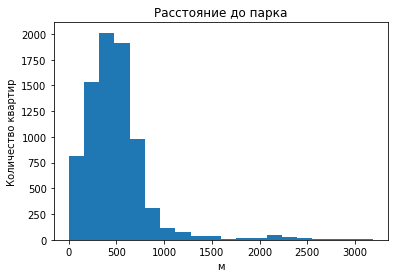

In [20]:
plt.hist(data['parks_nearest'], bins=20)
plt.title('Расстояние до парка')
plt.xlabel('м')
plt.ylabel('Количество квартир')
plt.show()

Большинство квартир расположены на расстоянии 400-600 метров от парка. 

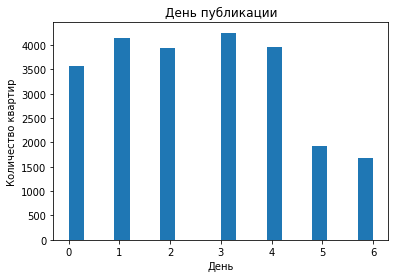

In [21]:
plt.hist(data['day_of_the_publication_week'], bins=20)
plt.title('День публикации')
plt.xlabel('День')
plt.ylabel('Количество квартир')
plt.show()

Чаще всего объявления публиковались в будние дни, в выходные их было меньше.

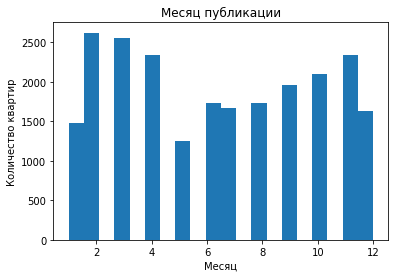

In [22]:
plt.hist(data['month_of_publication'], bins=20)
plt.title('Месяц публикации')
plt.xlabel('Месяц')
plt.ylabel('Количество квартир')
plt.show()

В феврале больше всего объявлений было опубликовано. Меньше всего - в мае.

In [23]:
data['days_exposition'].describe()

count    20284.000000
mean       180.564829
std        219.602556
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Среднее время продажи - 181 день. Медианное время продажи - 95 дней. 
Межквартильный размах: от 45 до 231 дня.
Быстрой продажей можно назвать срок в 45 дней(Q1). Долгая продажа - 231 день.

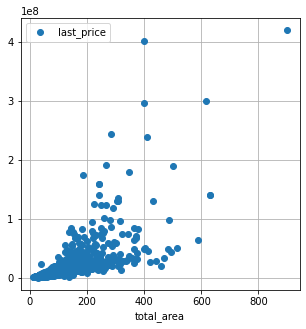

            last_price  total_area
last_price    1.000000    0.741699
total_area    0.741699    1.000000 



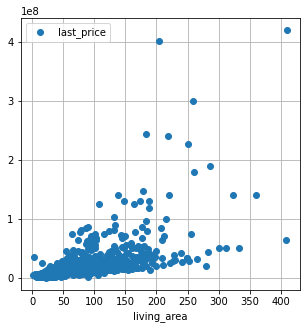

             last_price  living_area
last_price     1.000000     0.629258
living_area    0.629258     1.000000 



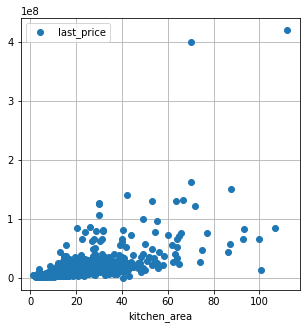

              kitchen_area  last_price
kitchen_area      1.000000    0.321293
last_price        0.321293    1.000000 



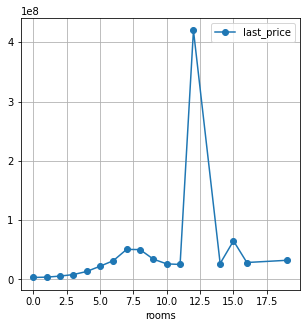

            last_price     rooms
last_price    1.000000  0.443383
rooms         0.443383  1.000000 



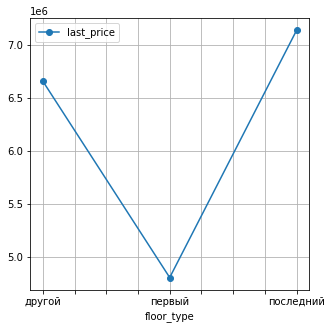

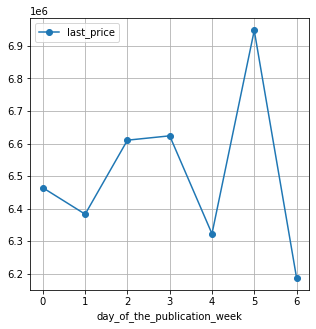

                             day_of_the_publication_week  last_price
day_of_the_publication_week                     1.000000    0.318051
last_price                                      0.318051    1.000000 



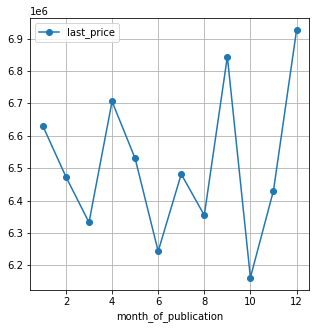

                      last_price  month_of_publication
last_price              1.000000             -0.021347
month_of_publication   -0.021347              1.000000 



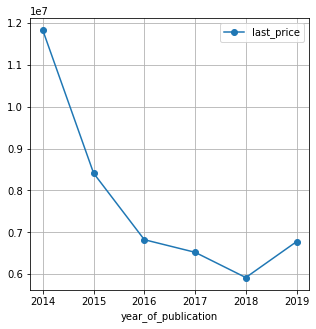

                     last_price  year_of_publication
last_price             1.000000            -0.055372
year_of_publication   -0.055372             1.000000 



In [24]:
# цена от общей площади
(data.pivot_table(index='total_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5)))
plt.show()
print(data.pivot_table(index='floor', values=['total_area', 'last_price']).corr(),'\n')

# цена от жилой площади
(data.pivot_table(index='living_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5)))
plt.show()
print(data.pivot_table(index='floor', values=['living_area', 'last_price']).corr(),'\n')

# цена от площади кухни
(data.pivot_table(index='kitchen_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5)))
plt.show()
print(data.pivot_table(index='floor', values=['kitchen_area', 'last_price']).corr(),'\n')

# цена от числа комнат
(data.pivot_table(index='rooms', values='last_price')
    .plot(grid=True, style='o-', figsize=(5, 5)))
plt.show()
print(data.pivot_table(index='floor', values=['rooms', 'last_price']).corr(),'\n')

# цена от этажа, на котором расположена квартира (первый, последний, другой);
(data.pivot_table(index='floor_type', values='last_price')
    .plot(grid=True, style='o-', figsize=(5, 5)))
plt.show()

# цена от даты размещения (день недели, месяц, год)
(data.pivot_table(index='day_of_the_publication_week', values='last_price')
    .plot(grid=True, style='o-', figsize=(5, 5)))
plt.show()
print(data.pivot_table(index='floor', values=['day_of_the_publication_week', 'last_price']).corr(),'\n')

(data.pivot_table(index='month_of_publication', values='last_price')
    .plot(grid=True, style='o-', figsize=(5, 5)))
plt.show()
print(data.pivot_table(index='floor', values=['month_of_publication', 'last_price']).corr(),'\n')

(data.pivot_table(index='year_of_publication', values='last_price')
    .plot(grid=True, style='o-', figsize=(5, 5)))
plt.show()
print(data.pivot_table(index='floor', values=['year_of_publication', 'last_price']).corr(),'\n')

Чем больше площадь квартиры, тем выше её стоимость.
Количество комнат в квартире тоже влияет на её цену.
Первый этаж влияет на стоимость квартиры (на первом этаже дешевле, дороже на последнем этаже).
Квартиры подешевели в 2016-2018 годах. В 2019 году цены снова стали повышаться.

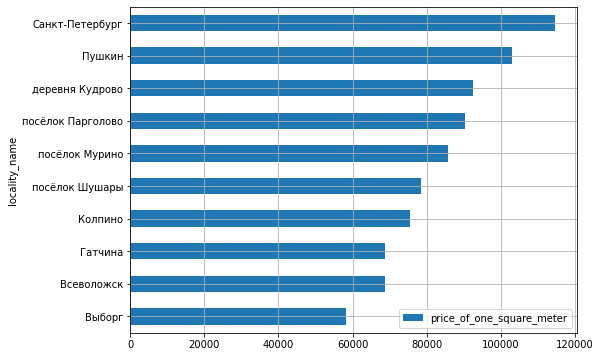

,price_of_one_square_meter
locality_name,
Санкт-Петербург,114661.924401
Пушкин,103079.873482
деревня Кудрово,92473.547576
посёлок Парголово,90205.423758
посёлок Мурино,85629.568678
посёлок Шушары,78551.344545
Колпино,75443.972838
Гатчина,68746.146763
Всеволожск,68670.459639


In [25]:
# посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. 
# выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.
# сравним среднюю стоимость квадратного метра в топ-10 городов по числу объявлений
top_10 = data['locality_name'].value_counts().head(10)
top_10
top_10_pivot = data.query('locality_name in @top_10.index').pivot_table(index='locality_name', values='price_of_one_square_meter')
top_10_pivot.sort_values(by='price_of_one_square_meter', ascending=False)
# отобразим на графике среднюю цену квадратного метра в топ 10 населенных пунктах
top_10_pivot.sort_values(by='price_of_one_square_meter').plot(kind='barh', legend=True, grid=True, figsize=(8, 6))
plt.show()
top_10_pivot.sort_values(by='price_of_one_square_meter', ascending=False)

Из графика видно, что наибольшая средняя цена за 1 квадратный метр в Санкт-Петербурге. Вполне логично. Далее идет Пушкин, возможно по тому, что там много достопримечательностей. Наименьшая цена за квадратный метр в Выборге.

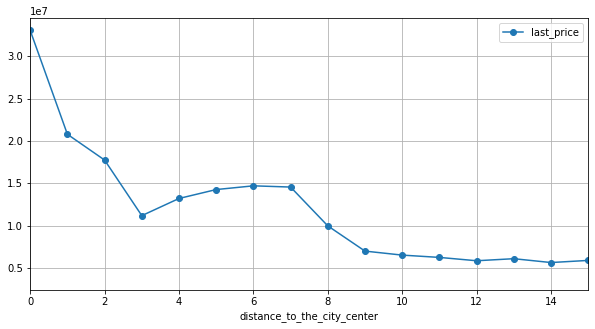

In [26]:
(data.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='distance_to_the_city_center', values='last_price')
    .plot(grid=True, style='o-', xlim=(0,15), figsize=(10, 5)))
plt.show()

График показывает, что на определенном этапе, а именно в точке 8(км) цена снижается и график выравнивается.  Следовательно, после 8 км цена на квартиру падает. Самая большая цена квартира у центра (1 км).  Максимальная стоимость в зоне у самого центра(до 1 км).

### Общий вывод

На стоимость квартиры влияет её площадь, чем площадь больше, тем стоимость квартиры выше.
На стоимость квартиры влияет число комнат, чем больше комнат в квартире, тем стоимость квартиры выше.
На стоимость квартиры влияет расстояние до центра города. Чем ближе квартира располагается к центру, тем выше ее стоимость.

Сложилось представление о том, какие квартиры встречаются чаще всего (типичные квартиры).
Это квартиры с общей площадью, приблизительно равной 45 м2; с площадью кухни около 8м2; стоимостью около 4 миллионов; однокомнатные или двухкомнатные; с высотой потолков 2,7м; располагающиеся на 1,2 или 3 этаже, в доме, где 5 или 9 этажей всего; на расстоянии от центра около 10 км; от аэропорта - 17-22км; от парка - 500м.

В ходе исследования было выявлено, что:
обычно продажа квартиры занимает около 100 дней;
самая высокая средняя стоимость квадратного метра в Санкт-Петербурге - 114 662(топ-10 населенных пунктов по количеству объявлений).
самая низкая средняя стоимость квадратного метра в Выборге - 58 190(топ-10 населенных пунктов по количеству объявлений).